In [43]:
import joblib
import pandas as pd
import seaborn as sb
import glob
import matplotlib.pyplot as plt
import truvari
from sklearn.metrics import roc_curve, roc_auc_score
sb.set()

In [219]:
parts = []
for i in glob.glob("../data/ss_discovery/grch38/*/data.df"):
    d = joblib.load(i)
    d["sample"] = i.split('/')[-2]
    parts.append(d)
data = pd.concat(parts)
data = data[~(data["sample"] == "NA18939")]
idx = data[(data["qual"] == 0) & (data["state"].isin(["tp", "fp"]))].index
data = data.drop(index=idx)

In [220]:
metadata = pd.read_csv("../lra_sr_metadata.txt", sep="\t")
metadata = metadata.set_index("Individual")

In [221]:
def acc(grp):
    view = grp["state"].value_counts()
    fp = view["fp"] if "fp" in view else 0
    tp = view["tp"] if "tp" in view else 0
    fn = view["fn"] if "fn" in view else 0
    tpbase = view["tpbase"] if "tpbase" in view else 0
    if tp + fp != 0:
        precision = tp / (tp + fp)
    else:
        precision = 0
    if tpbase + fn != 0:
        recall = tpbase / (tpbase + fn)
    else:
        recall = 0
    neum = recall * precision
    denom = recall + precision
    if denom != 0:
        f1 = 2 * (neum / denom)
    else:
        f1 = None
    return precision, recall, f1

summary = []
for samp, dat in data.groupby(["sample"]):
    summary.append([samp, metadata.loc[samp]["Superpopulation code"], *acc(dat)])
summary = pd.DataFrame(summary, columns=["Sample", "Superpopulation", "Precision", "Recall", "F1"])

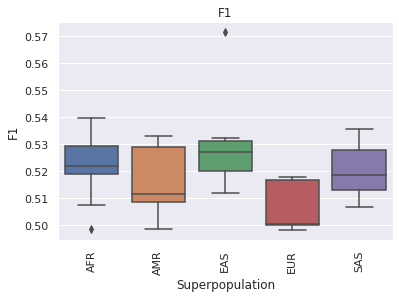

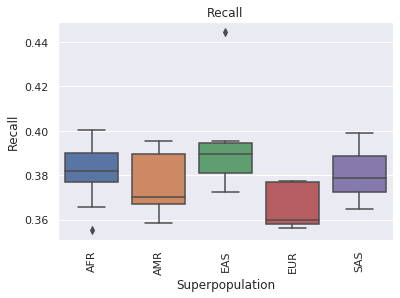

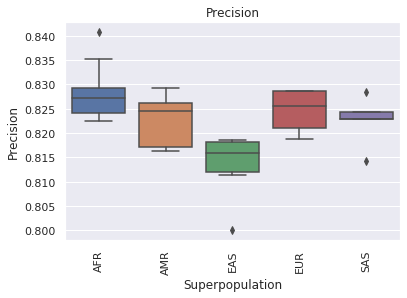

In [222]:
for y in ["F1", "Recall", "Precision"]:
    p = sb.boxplot(data=summary.sort_values(["Superpopulation"]), x="Superpopulation", y=y)#, hue="Superpopulation")
    hide=plt.xticks(rotation=90)
    p.set(title=y)
    plt.show()

In [223]:
summary.describe()

,Precision,Recall,F1
count,32.000000,32.000000,32.000000
mean,0.823076,0.380686,0.520291
std,0.007523,0.017676,0.015237
min,0.800084,0.355385,0.498246
25%,0.818554,0.369354,0.510632
50%,0.823993,0.379777,0.519742
75%,0.828470,0.389760,0.528096
max,0.840782,0.444313,0.571342


In [224]:
summary = []
for samp, dat in data.groupby(["sample", "svtype"]):
    summary.append([samp[0], metadata.loc[samp[0]]["Superpopulation code"], samp[1], *acc(dat)])
summary = pd.DataFrame(summary, columns=["Sample", "Superpopulation", "svtype", "Precision", "Recall", "F1"])

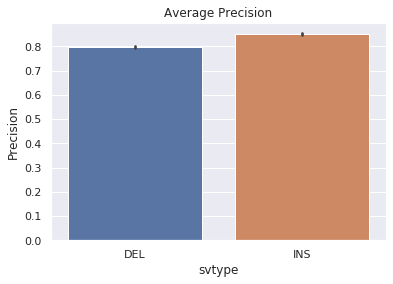

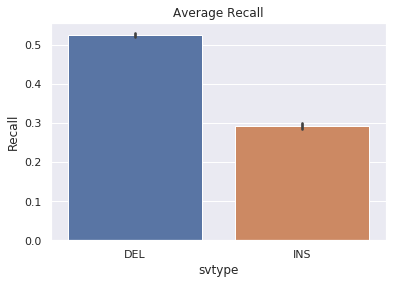

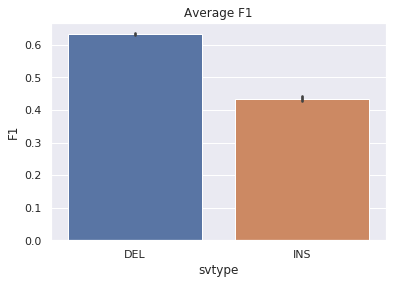

In [225]:
for i in ["Precision", "Recall", "F1"]:
    p = sb.barplot(data=summary, x="svtype", y=i)
    p.set(title="Average " + i)
    plt.show()

In [226]:
summary = []
for samp, dat in data.groupby(["sample", "svtype", "szbin"]):
    summary.append([samp[0], metadata.loc[samp[0]]["Superpopulation code"], samp[1], samp[2], *acc(dat)])
summary = pd.DataFrame(summary, columns=["Sample", "Superpopulation", "svtype", "szbin", "Precision", "Recall", "F1"])
summary["szbin"] = summary["szbin"].astype(truvari.SZBINTYPE)

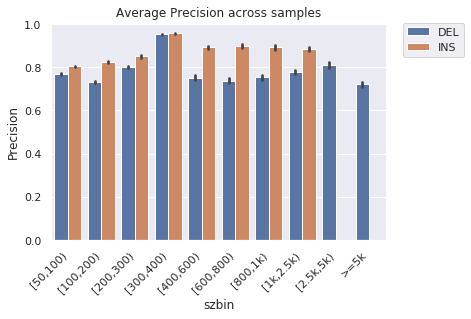

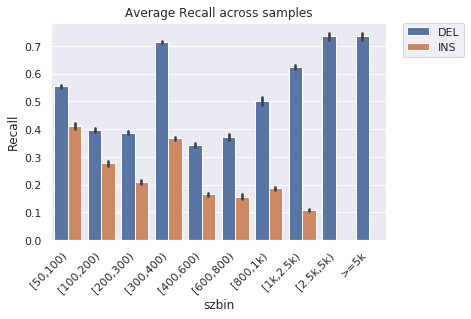

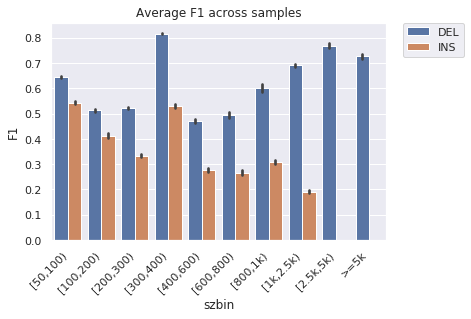

In [227]:
p = sb.barplot(data=summary, x="szbin", y="Precision", hue="svtype", order=truvari.SZBINS[1:])
p.set(title="Average Precision across samples")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = plt.xticks(rotation=45, ha="right")
plt.show()

p = sb.barplot(data=summary, x="szbin", y="Recall", hue="svtype", order=truvari.SZBINS[1:])
p.set(title="Average Recall across samples")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = plt.xticks(rotation=45, ha="right")
plt.show()

p = sb.barplot(data=summary, x="szbin", y="F1", hue="svtype", order=truvari.SZBINS[1:])
p.set(title="Average F1 across samples")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = plt.xticks(rotation=45, ha="right")
plt.show()

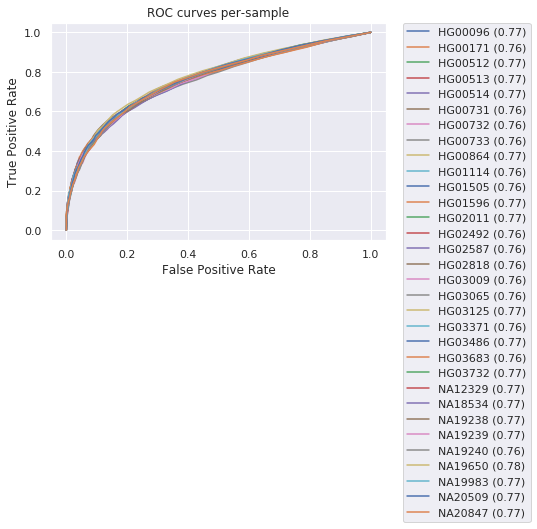

In [228]:
for samp, dat in data.groupby("sample"):
    view = dat[dat["state"].isin(["tp", "fp"])]
    #view.loc[view["state"] == "fn", "qual"] = -1
    fpr, tpr, thresholds = roc_curve(view["state"] == "tp", view["qual"])
    auc = roc_auc_score(view["state"] == "tp", view["qual"])
    plt.plot(fpr, tpr, label="%s (%.2f)" % (samp, auc))
plt.title("ROC curves per-sample")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)